Implementing some form of prefix tuning. Relevant literature:

* Li and Liang (2021) [Prefix Tuning](https://arxiv.org/abs/2101.00190).
* https://arxiv.org/abs/2303.16199

In [140]:
import torch
from transformers import GPTNeoXForCausalLM, AutoTokenizer

from tqdm import tqdm

In [141]:
step = "143000"
model_size = "70m"

In [142]:
model = GPTNeoXForCausalLM.from_pretrained(
    f"EleutherAI/pythia-{model_size}-deduped",
    revision=f"step{step}",
    cache_dir=f"./pythia-{model_size}-deduped/step{step}",
)

tokenizer = AutoTokenizer.from_pretrained(
    f"EleutherAI/pythia-{model_size}-deduped",
    revision=f"step{step}",
    cache_dir=f"./pythia-{model_size}-deduped/step{step}",
)
tokenizer.pad_token_id = tokenizer.eos_token_id

Quick model inference to download models and tokenizers

In [143]:
inputs = tokenizer("Hello, I am", return_tensors="pt")
tokens = model.generate(**inputs, pad_token_id=tokenizer.eos_token_id)
tokenizer.decode(tokens[0])

/Users/timodenk/.pyenv/versions/3.9.4/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'Hello, I am looking for a way to get my name in the mail. I am looking for'

In [144]:
from typing import *

from transformers.models import gpt_neox

In [145]:
class DebugBlock(gpt_neox.GPTNeoXLayer):

    def forward(
        self,
        hidden_states: Optional[torch.FloatTensor],
        attention_mask: Optional[torch.FloatTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = False,
        layer_past: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: Optional[bool] = False,
    ):
        print("hidden_states", hidden_states.shape)
        print("attention_mask", attention_mask.shape)
        print(f"{attention_mask=}")
        print("position_ids", position_ids.shape)
        print(f"{position_ids=}")
        if head_mask is not None:
            print("head_mask", head_mask.shape)
        print(f"{use_cache=}")
        return super().forward(hidden_states, attention_mask, position_ids,
                        head_mask, use_cache, layer_past, output_attentions)


Replace one block in our model to get some info on shapes and tensor content.

In [146]:
original_forward = model.gpt_neox.layers[2].forward
model.gpt_neox.layers[2].forward = DebugBlock(model.config).forward

In [147]:
inputs = tokenizer(
    ["Hello, I am", "A"], return_tensors="pt", padding='longest', return_attention_mask=True)
tokens = model(**inputs)

hidden_states torch.Size([2, 4, 512])
attention_mask torch.Size([2, 1, 1, 4])
attention_mask=tensor([[[[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00]]],


        [[[-0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38]]]])
position_ids torch.Size([1, 4])
position_ids=tensor([[0, 1, 2, 3]])
use_cache=True


In [148]:
# Restore original forward function.
model.gpt_neox.layers[2].forward = original_forward

Define prefix tuning block which can act as a stand-in replacement of the vanilla Transformer block (`gpt_neox.GPTNeoXLayer`).

In [149]:
class PrefixTuningBlock(torch.nn.Module):
    def __init__(self, vanilla_block: gpt_neox.GPTNeoXLayer, input_has_prefix: bool, prefix_len: int):
        super().__init__()
        self.vanilla_block = vanilla_block
        d_model = self.vanilla_block.attention.query_key_value.in_features
        prefix_size = (prefix_len, d_model)
        self.prefix = torch.nn.Parameter(
            torch.randn(prefix_size), requires_grad=True)

        self._prefix_len = prefix_len
        self._input_has_prefix = input_has_prefix

    def forward(
        self,
        hidden_states: Optional[torch.FloatTensor],
        attention_mask: Optional[torch.FloatTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = False,
        layer_past: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: Optional[bool] = False,
    ):
        # Update hidden states.
        assert hidden_states is not None, "Prefix tuning requires hidden_states."
        if self._input_has_prefix:
            hidden_states = hidden_states[:, self._prefix_len:, ...]
        batch_size = hidden_states.shape[0]
        prefix_repated = self.prefix.unsqueeze(0).repeat(batch_size, 1, 1)
        hidden_states = torch.concat(
            [prefix_repated, hidden_states], dim=1)

        # Update attention mask.
        assert attention_mask is not None, "Prefix tuning requires attention_mask."
        batch_size = attention_mask.shape[0]
        assert attention_mask.shape[1] == 1
        assert attention_mask.shape[2] == 1
        zero_prefix = torch.zeros((batch_size, 1, 1, self._prefix_len))
        attention_mask = torch.concat(
            [zero_prefix, attention_mask], dim=-1)

        # Update position ids.
        assert position_ids is not None, "Prefix tuning requires position_ids."
        assert position_ids.shape[0] == 1
        seq_len = attention_mask.shape[-1]
        updated_position_ids = torch.arange(
            0, seq_len, device=position_ids.device, dtype=position_ids.dtype).unsqueeze(0)

        return self.vanilla_block.forward(
            hidden_states, attention_mask, updated_position_ids, head_mask, use_cache, layer_past, output_attentions)


In [150]:
prefix_len = 3

for i in tqdm(range(len(model.gpt_neox.layers))):
    vanilla_block = model.gpt_neox.layers[i]
    is_first_block = i == 0
    new_block = PrefixTuningBlock(
        vanilla_block, input_has_prefix=(not is_first_block), prefix_len=prefix_len)
    model.gpt_neox.layers[i] = new_block

100%|██████████| 6/6 [00:00<00:00, 3911.38it/s]


In [151]:
training_set = 'This is PDG!'
training_data = tokenizer(training_set, return_tensors='pt')

# Target generation 
target = torch.concat([
    training_data['input_ids'][:,1:], # Batch x (seq - 1)
    torch.tensor([[tokenizer.eos_token_id]]) # Batch x 1 
    ], axis=-1)

In [152]:
{k: v.shape for k, v in training_data.items()}

{'input_ids': torch.Size([1, 5]), 'attention_mask': torch.Size([1, 5])}

In [153]:
epochs = 300
learning_rate = 1e-4
losses = []

model.train()
optimizer = torch.optim.Adam(
    params=[p for n, p in model.named_parameters() if n.endswith("prefix")],
    lr=learning_rate
)

ce_loss_fn = torch.nn.CrossEntropyLoss()

for step in range(epochs):
    optimizer.zero_grad()
    logits_with_prefix = model(**training_data).logits.permute([0, 2, 1])
    logits = logits_with_prefix[:, :, prefix_len:]
    loss = ce_loss_fn(logits, target)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()


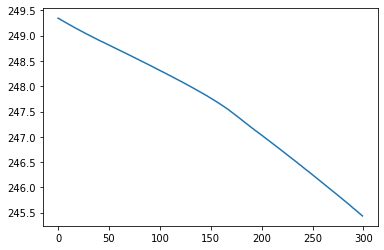

In [154]:
import matplotlib.pyplot as plt

plt.plot(losses);

In [155]:
losses[-1]

245.43429565429688

In [156]:
model.eval()
inputs = tokenizer("this", return_tensors="pt")
tokens = model.generate(**inputs, pad_token_id=tokenizer.pad_token_id)
tokenizer.decode(tokens[0])

NameError: name 'lora_model' is not defined